In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import pickle
import numpy as np
import pandas as pd
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from sklearn.preprocessing import MinMaxScaler

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
import torch

from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE, DistributionLoss, NormalDistributionLoss, LogNormalDistributionLoss

In [3]:
class MultivariateDistributionLoss(DistributionLoss):
    """Base class for multivariate distribution losses.

    Class should be inherited for all multivariate distribution losses, i.e. if a batch of values
    is predicted in one go and the batch dimension is not independent, but the time dimension still
    remains independent.
    """

    def sample(self, y_pred, n_samples: int) -> torch.Tensor:
        """
        Sample from distribution.

        Args:
            y_pred: prediction output of network (shape batch_size x n_timesteps x n_paramters)
            n_samples (int): number of samples to draw

        Returns:
            torch.Tensor: tensor with samples  (shape batch_size x n_timesteps x n_samples)
        """
        dist = self.map_x_to_distribution(y_pred)
        samples = dist.sample((n_samples,)).permute(
            2, 1, 0
        )  # returned as (n_samples, n_timesteps, batch_size), so reshape to (batch_size, n_timesteps, n_samples)
        return samples


    def to_prediction(self, y_pred: torch.Tensor) -> torch.Tensor:
        """
        Convert network prediction into a point prediction.

        Args:
            y_pred: prediction output of network

        Returns:
            torch.Tensor: mean prediction
        """
        distribution = self.map_x_to_distribution(y_pred)

        return distribution.mean.transpose(0, 1)  # switch to batch_size x n_timesteps


    def loss(self, y_pred: torch.Tensor, y_actual: torch.Tensor) -> torch.Tensor:
        """
        Calculate negative likelihood

        Args:
            y_pred: network output
            y_actual: actual values

        Returns:
            torch.Tensor: metric value on which backpropagation can be applied
        """
        distribution = self.map_x_to_distribution(y_pred)
        # calculate one number and scale with batch size
        loss = -distribution.log_prob(y_actual.transpose(0, 1)).sum() * y_actual.size(0)
        return loss

In [4]:
from torch import distributions
from pytorch_forecasting.metrics import BaseEstimator
import torch.nn.functional as F
class MultivariateNormalDistributionLoss(MultivariateDistributionLoss):
    """
    Multivariate low-rank normal distribution loss.

    Use this loss to make out of a DeepAR model a DeepVAR network.

    Requirements for original target normalizer:
        * not normalized in log space (use :py:class:`~LogNormalDistributionLoss`)
        * not coerced to be positive
    """

    distribution_class = distributions.LowRankMultivariateNormal

    def __init__(
        self,
        name: str = None,
        quantiles: List[float] = [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98],
        reduction: str = "mean",
        rank: int = 10,
        sigma_init: float = 1.0,
        sigma_minimum: float = 1e-3,
    ):
        """
        Initialize metric

        Args:
            name (str): metric name. Defaults to class name.
            quantiles (List[float], optional): quantiles for probability range.
                Defaults to [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98].
            reduction (str, optional): Reduction, "none", "mean" or "sqrt-mean". Defaults to "mean".
            rank (int): rank of low-rank approximation for covariance matrix. Defaults to 10.
            sigma_init (float, optional): default value for diagonal covariance. Defaults to 1.0.
            sigma_minimum (float, optional): minimum value for diagonal covariance. Defaults to 1e-3.
        """
        super().__init__(name=name, quantiles=quantiles, reduction=reduction)
        self.rank = rank
        self.sigma_minimum = sigma_minimum
        self.sigma_init = sigma_init
        self.distribution_arguments = list(range(2 + rank))

        # determine bias
        self._diag_bias: float = self.inv_softplus(self.sigma_init**2) if self.sigma_init > 0.0 else 0.0

    def map_x_to_distribution(self, x: torch.Tensor) -> distributions.Normal:
        x = x.permute(1, 0, 2)
        return self.distribution_class(
            loc=x[..., 0],
            cov_factor=x[..., 2:],
            cov_diag=x[..., 1],
        )


    @staticmethod
    def validate_encoder(encoder: BaseEstimator):
        assert encoder.transformation not in [
            "log",
            "log1p",
        ], "Use MultivariateLogNormalDistributionLoss for log scaled data"  # todo: implement
        assert encoder.transformation not in [
            "softplus",
            "relu",
        ], "Cannot use NormalDistributionLoss for positive data"
        assert encoder.transformation not in ["logit"], "Cannot use bound transformation such as 'logit'"

    def rescale_parameters(
        self, parameters: torch.Tensor, target_scale: torch.Tensor, encoder: BaseEstimator
    ) -> torch.Tensor:
#         self.validate_encoder(encoder)

        # scale
        loc = encoder(dict(prediction=parameters[..., 0], target_scale=target_scale)).unsqueeze(-1)
        scale = (
            F.softplus(parameters[..., 1].unsqueeze(-1) + self._diag_bias) + self.sigma_minimum**2
        ) * target_scale[..., 1, None, None] ** 2

        cov_factor = parameters[..., 2:] * target_scale[..., 1, None, None]
        return torch.concat([loc, scale, cov_factor], dim=-1)


    def inv_softplus(self, y):
        if y < 20.0:
            return np.log(np.exp(y) - 1.0)
        else:
            return y

## Data

In [5]:
from pytorch_forecasting.data.encoders import GroupNormalizer
with open('../data/crypto_currency.pickle', 'rb') as f:
    data = pickle.load(f)

In [6]:
d1 = data['KRW-ZIL']
d1 = d1.sort_values('candle_date_time_kst')
d1['time_index'] = np.arange(len(d1))
date_index = d1[['time_index', 'candle_date_time_kst']]

In [7]:
res_data = pd.DataFrame()
for i, key in enumerate(data.keys()):
    tmp = data[key]
#     if tmp.shape[0] == 720:
    tmp_1 = pd.merge(tmp, date_index, on ='candle_date_time_kst')
    tmp_df_1 = tmp_1[['market', 'candle_acc_trade_volume', 'time_index', 'candle_date_time_kst', 'trade_price']]
    tmp_df_1.reset_index(inplace = True)
    try:
        res_data = pd.concat([res_data, tmp_df_1])
    except Exception as e:
        pass    

In [8]:
res_data.shape

(101553, 6)

In [9]:
gn = GroupNormalizer(
    groups= ['market'],
    scale_by_group = True
)

scaled_trade_price = gn.fit_transform(res_data['trade_price'], res_data, return_norm = True)

scaled_volume = gn.fit_transform(res_data['candle_acc_trade_volume'], res_data, return_norm = True)

res_data['trade_price'] = scaled_trade_price[0]
res_data['candle_acc_trade_volume'] = scaled_volume[0]

res_data.dropna(inplace = True)

res_data.shape

(101553, 6)

In [10]:
res_data['new_idx'] = res_data['market'] + '_' + res_data['time_index'].astype(str)
res_data.drop_duplicates(subset = ['new_idx'], inplace = True)
res_data.sort_values(['market', 'time_index'], inplace = True)
res_data.set_index('new_idx', inplace = True)

In [11]:
# create dataset and dataloader
max_encoder_length = 30
max_prediction_length = 10

training_cutoff = res_data['time_index'].max() - max_prediction_length

In [12]:
training_cutoff

709

In [13]:
context_length = max_encoder_length
prediction_length = max_prediction_length

In [14]:
res_data['time_index'] = res_data['time_index'].astype(int)

In [15]:
res_data.reset_index(inplace = True)
res_data.drop(['new_idx'], axis = 1, inplace = True)

In [16]:
res_data.head()

,index,market,candle_acc_trade_volume,time_index,candle_date_time_kst,trade_price
0,0,BTC-AERGO,-0.334367,120,2019-12-22T09:00:00,-0.127470
1,1,BTC-AERGO,-0.330511,122,2019-12-24T09:00:00,-0.340098
2,2,BTC-AERGO,-0.182656,125,2019-12-27T09:00:00,-0.552727
3,3,BTC-AERGO,-0.331371,126,2019-12-28T09:00:00,-0.552727
4,4,BTC-AERGO,-0.324256,127,2019-12-29T09:00:00,-0.566902


In [17]:
training = TimeSeriesDataSet(
    res_data[lambda x: x.time_index <= training_cutoff],
    time_idx = 'time_index',
    target = 'trade_price',
    categorical_encoders = {'market': NaNLabelEncoder().fit(res_data.market)},
    group_ids = ['market'],
    time_varying_unknown_reals = ['trade_price'],
    max_encoder_length = context_length,
    max_prediction_length = prediction_length,
    allow_missing_timesteps=True
)

In [18]:
validation = TimeSeriesDataSet.from_dataset(
    training,
    res_data,
    min_prediction_idx = training_cutoff + 1
)

In [20]:
batch_size = 64
train_dataloader = training.to_dataloader(train = True, batch_size = batch_size, num_workers = 0)
val_dataloader = validation.to_dataloader(train = False, batch_size = batch_size, num_workers = 0)

# Calculate baseline error

In [21]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])

In [22]:
[y[0].shape for x, y in iter(val_dataloader)]

[torch.Size([64, 10]), torch.Size([64, 10]), torch.Size([64, 10])]

In [23]:
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)

tensor(0.3607)

In [26]:
pl.seed_everything(42)
trainer = pl.Trainer(gpus = 0, gradient_clip_val = .1)
net = DeepAR.from_dataset(
    training, 
    learning_rate=0.1,
    log_interval=10,
    log_val_interval=1,
    hidden_size=15,
    rnn_layers=3,
    loss=MultivariateNormalDistributionLoss(rank=10),
)

Global seed set to 42
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /home/kyle/course-material/notebooks/.lr_find_8e2cdbea-a360-47f5-8bc7-72cf53d90dac.ckpt


suggested learning rate: 3.548133892335755e-05


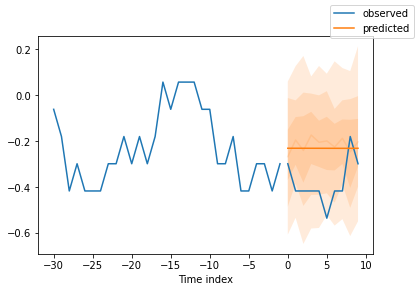

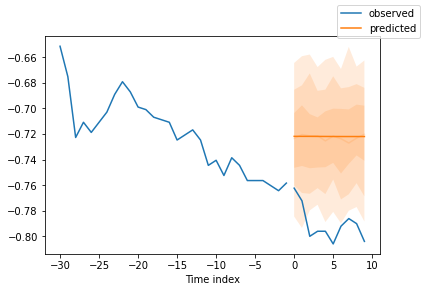

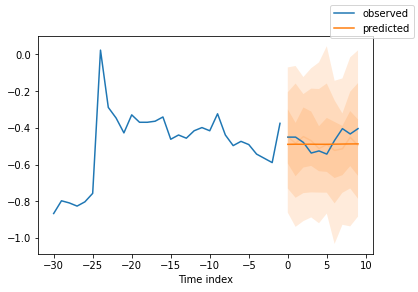

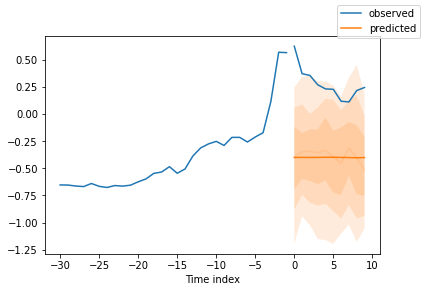

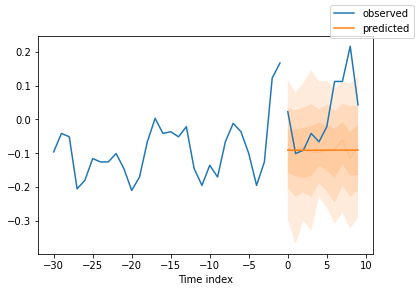

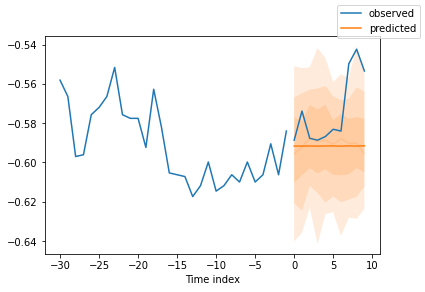

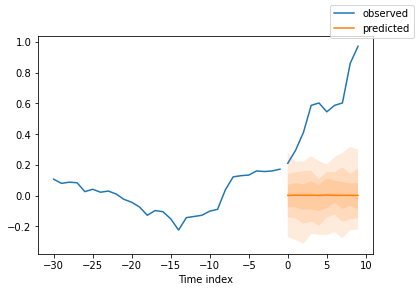

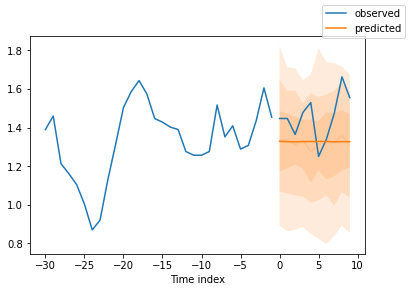

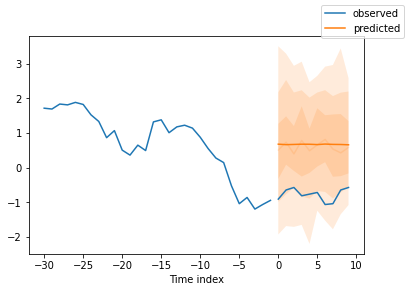

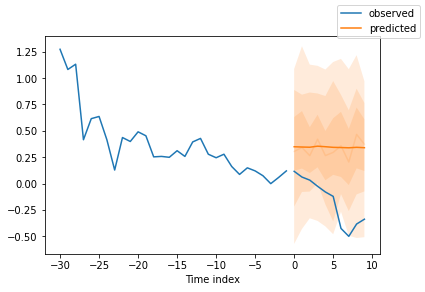

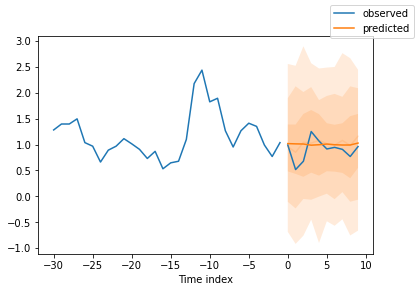

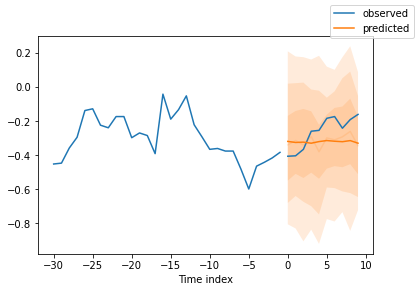

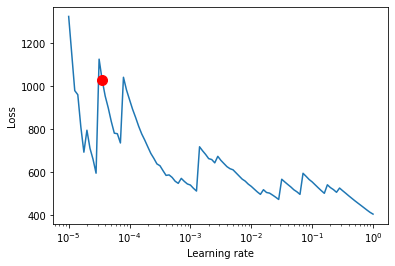

In [27]:
# find optimal learning rate
res = trainer.tuner.lr_find(net, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [39]:
net = DeepAR.from_dataset(
    training, 
    learning_rate=0.001,
    log_interval=10,
    log_val_interval=1,
    hidden_size=20,
    rnn_layers=2,
   loss = MultivariateNormalDistributionLoss()
)

In [40]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=True, mode="min")
lr_logger = LearningRateMonitor()

In [41]:
trainer = pl.Trainer(
    max_epochs = 100,
    gpus = 0,
    weights_summary = 'top',
    gradient_clip_val = .01,
    callbacks = [lr_logger, early_stop_callback],
    limit_train_batches = 30,
    enable_checkpointing = True,
    auto_lr_find = True,
    logger = TensorBoardLogger('./lightning_logs/deepAR')
)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [42]:
# torch.set_num_threads(10)

In [43]:
trainer.fit(
    net,
    train_dataloaders = train_dataloader,
    val_dataloaders = val_dataloader,
)

Missing logger folder: ./lightning_logs/deepAR/lightning_logs

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 0     
3 | rnn                    | LSTM                               | 5.2 K 
4 | distribution_projector | Linear                             | 252   
------------------------------------------------------------------------------
5.5 K     Trainable params
0         Non-trainable params
5.5 K     Total params
0.022     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: -36.509


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.238 >= min_delta = 0.0001. New best score: -37.747


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.863 >= min_delta = 0.0001. New best score: -39.610


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.273 >= min_delta = 0.0001. New best score: -41.883


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.692 >= min_delta = 0.0001. New best score: -44.575


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.786 >= min_delta = 0.0001. New best score: -47.361


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.390 >= min_delta = 0.0001. New best score: -49.751


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.828 >= min_delta = 0.0001. New best score: -51.579


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.434 >= min_delta = 0.0001. New best score: -53.013


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.138 >= min_delta = 0.0001. New best score: -54.151


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.688 >= min_delta = 0.0001. New best score: -54.839


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.770 >= min_delta = 0.0001. New best score: -55.609


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.262 >= min_delta = 0.0001. New best score: -55.871


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.441 >= min_delta = 0.0001. New best score: -56.313


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.706 >= min_delta = 0.0001. New best score: -57.018


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.815 >= min_delta = 0.0001. New best score: -57.833


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.747 >= min_delta = 0.0001. New best score: -58.580


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.526 >= min_delta = 0.0001. New best score: -59.106


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.346 >= min_delta = 0.0001. New best score: -59.452


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.639 >= min_delta = 0.0001. New best score: -60.091


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.606 >= min_delta = 0.0001. New best score: -60.697


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.293 >= min_delta = 0.0001. New best score: -60.990


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.552 >= min_delta = 0.0001. New best score: -61.542


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.112 >= min_delta = 0.0001. New best score: -61.654


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.276 >= min_delta = 0.0001. New best score: -61.931


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.369 >= min_delta = 0.0001. New best score: -62.300


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.330 >= min_delta = 0.0001. New best score: -62.630


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.418 >= min_delta = 0.0001. New best score: -63.048


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.533 >= min_delta = 0.0001. New best score: -63.581


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.967 >= min_delta = 0.0001. New best score: -64.548


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.649 >= min_delta = 0.0001. New best score: -65.197


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.379 >= min_delta = 0.0001. New best score: -65.576


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.406 >= min_delta = 0.0001. New best score: -65.981


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.967 >= min_delta = 0.0001. New best score: -66.948


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.469 >= min_delta = 0.0001. New best score: -67.417


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.599 >= min_delta = 0.0001. New best score: -68.016


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.563 >= min_delta = 0.0001. New best score: -68.579


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.421 >= min_delta = 0.0001. New best score: -69.000


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.749 >= min_delta = 0.0001. New best score: -69.749


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.947 >= min_delta = 0.0001. New best score: -70.696


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.807 >= min_delta = 0.0001. New best score: -71.502


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.162 >= min_delta = 0.0001. New best score: -71.664


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.086 >= min_delta = 0.0001. New best score: -71.750


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.499 >= min_delta = 0.0001. New best score: -72.249


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.411 >= min_delta = 0.0001. New best score: -72.660


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.376 >= min_delta = 0.0001. New best score: -73.036


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.030 >= min_delta = 0.0001. New best score: -73.066


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.047 >= min_delta = 0.0001. New best score: -73.113


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.613 >= min_delta = 0.0001. New best score: -73.726


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.209 >= min_delta = 0.0001. New best score: -73.935


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.498 >= min_delta = 0.0001. New best score: -74.433


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.594 >= min_delta = 0.0001. New best score: -75.027


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.038 >= min_delta = 0.0001. New best score: -75.064


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.481 >= min_delta = 0.0001. New best score: -75.545


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.080 >= min_delta = 0.0001. New best score: -75.625


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.456 >= min_delta = 0.0001. New best score: -76.081


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.092 >= min_delta = 0.0001. New best score: -76.172


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.281 >= min_delta = 0.0001. New best score: -76.454


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.270 >= min_delta = 0.0001. New best score: -76.724


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: -76.724. Signaling Trainer to stop.


In [34]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)

In [35]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(0.1782)

In [36]:
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0
)

In [44]:
predictions, _ = best_model.predict(val_dataloader, return_x=True, n_samples=100)

In [45]:
predictions.shape

torch.Size([192, 10])

In [46]:
actuals.shape

torch.Size([192, 10])

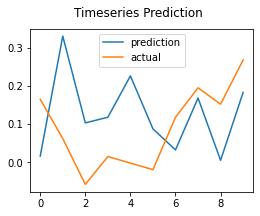

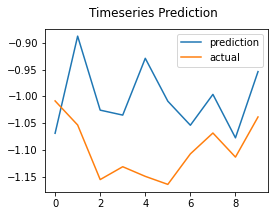

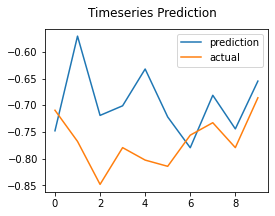

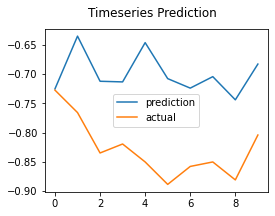

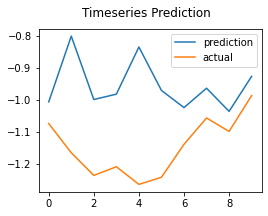

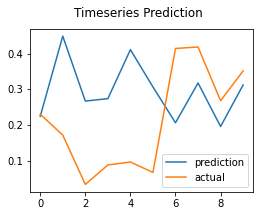

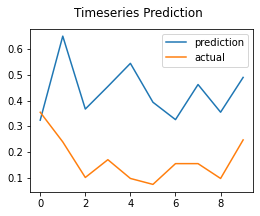

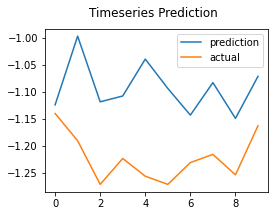

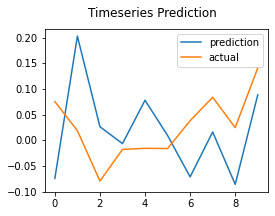

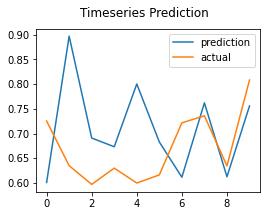

In [50]:
for i in np.arange(100, 110):
    plt.figure(figsize=(4, 3))
    plt.plot(predictions[i], label='prediction')
    plt.plot(actuals[i], label='actual')
    plt.suptitle('Timeseries Prediction')
    plt.legend()
    plt.show()

In [53]:
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
)
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True, n_samples=100)
# for idx in range(2):  # plot 10 examples
for i in range(10):
    best_model.plot_prediction(x, raw_predictions, idx=i, add_loss_to_title=True)

AssertionError: allow_missing_timesteps should be False for time-synchronized mini-batches

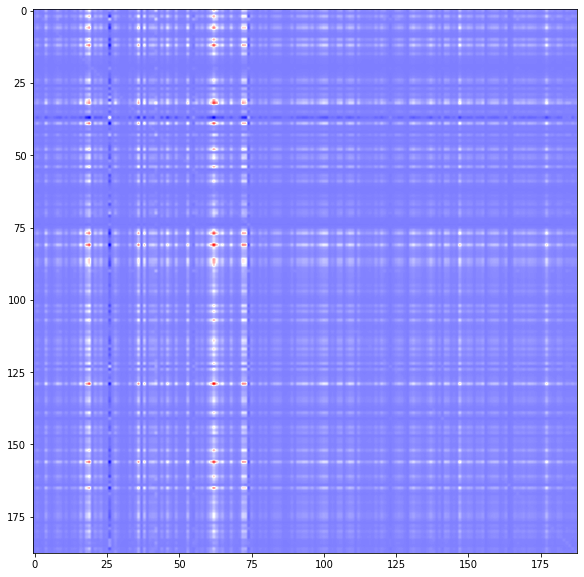

In [257]:
cov_matrix = net.loss.map_x_to_distribution(
    net.predict(val_dataloader, mode=("raw", "prediction"), n_samples=None)
).covariance_matrix.mean(0)

# normalize the covariance matrix diagnoal to 1.0
correlation_matrix = cov_matrix / torch.sqrt(torch.diag(cov_matrix) * torch.diag(cov_matrix).T)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(correlation_matrix, cmap="bwr");